In [ ]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
from keras import regularizers

In [ ]:
NB_WORDS=100
NB_START_EPOCHS=20
BATCH_SIZE = 512 
MAX_LEN = 20 
root = Path("/content/housepricedata.csv")
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

In [ ]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
  model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
  history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
  return history


In [ ]:
def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()  

In [ ]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

In [ ]:
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

In [ ]:
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

In [ ]:
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [ ]:
def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [ ]:
df = pd.read_csv("/Tweets.csv")
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
#df.text = df.text.apply(remove_stopwords)
df.text=df.text.apply(remove_mentions)

In [ ]:
(X_train, X_test, y_train, y_test) = train_test_split(df.text, 
                                                    df.airline_sentiment, 
                                                    test_size=0.1, 
                                                    random_state=37)

In [ ]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True, char_level=False, split=' ') 
tk.fit_on_texts(X_train)

In [ ]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, 
                                                                y_train_oh,
                                                                test_size=0.1, 
                                                                random_state=37)

In [56]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
#df.text = df.text.apply(remove_stopwords)
#base_model.name = 'Baseline model'

Minimum validation loss reached in epoch 16


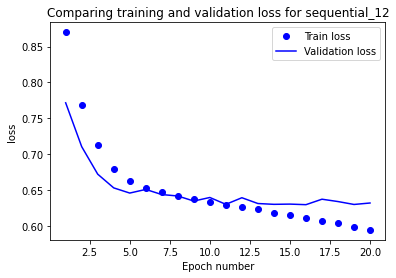

In [ ]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

Minimum validation loss reached in epoch 20


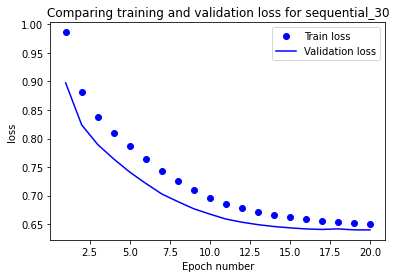

In [57]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
#reduced_model.name = 'Reduced model'
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

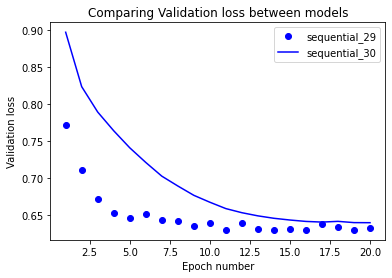

In [58]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

In [60]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
#reg_model.name = 'L2 Regularization model'
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch 18


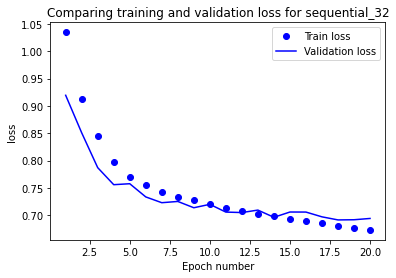

In [61]:
eval_metric(reg_model, reg_history, 'loss')

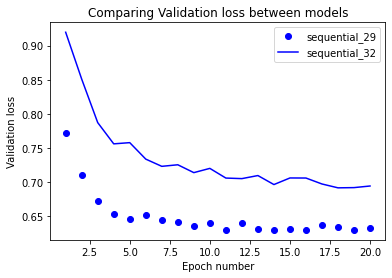

In [62]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

Minimum validation loss reached in epoch 20


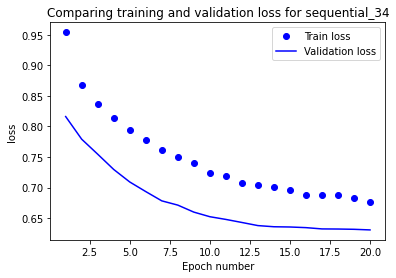

In [64]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
#drop_model.name = 'Dropout layers model'
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

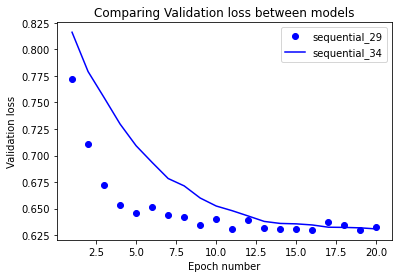

In [65]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

In [67]:
#base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 1ms/step - loss: 0.6510 - accuracy: 0.7199

Test accuracy: 71.99%
46/46 [==============================] - 0s 1ms/step - loss: 0.7191 - accuracy: 0.7206

Test accuracy: 72.06%
46/46 [==============================] - 0s 1ms/step - loss: 0.6536 - accuracy: 0.7172

Test accuracy: 71.72%
